https://satijalab.org/seurat/archive/v3.1/atacseq_integration_vignette.html![image.png](attachment:image.png)

https://satijalab.org/seurat/archive/v3.0/atacseq_integration_vignette.html
Note: this data isn't matched.
Data from https://satijalab.org/signac/articles/pbmc_multiomic.html

In [11]:
library(Seurat)
library(ggplot2)
library(patchwork)

In [2]:
data <- readRDS("../../data/pbmc/data_list.rds")
peaks <- data$Peaks
genes = data[['Gene Expression']]

In [47]:
str(data)

List of 2
 $ Gene Expression:Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:23508033] 17 48 53 59 86 109 113 137 168 170 ...
  .. ..@ p       : int [1:11910] 0 3308 5204 8108 8954 11236 12589 15650 17341 20369 ...
  .. ..@ Dim     : int [1:2] 36601 11909
  .. ..@ Dimnames:List of 2
  .. .. ..$ : chr [1:36601] "MIR1302-2HG" "FAM138A" "OR4F5" "AL627309.1" ...
  .. .. ..$ : chr [1:11909] "AAACAGCCAAGGAATC-1" "AAACAGCCAATCCCTT-1" "AAACAGCCAATGCGCT-1" "AAACAGCCACACTAAT-1" ...
  .. ..@ x       : num [1:23508033] 1 1 1 1 1 1 1 1 1 6 ...
  .. ..@ factors : list()
 $ Peaks          :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:85596796] 12 16 25 27 28 30 34 37 38 39 ...
  .. ..@ p       : int [1:11910] 0 13878 21131 27659 28565 31888 36155 47788 55033 63635 ...
  .. ..@ Dim     : int [1:2] 108377 11909
  .. ..@ Dimnames:List of 2
  .. .. ..$ : chr [1:108377] "chr1:10109-10357" "chr1:180730-181630" "chr1:191491-191736" "ch

In [5]:
# create a gene activity matrix from the peak matrix and GTF, using chromosomes 1:22, X, and Y.
# Peaks that fall within gene bodies, or 2kb upstream of a gene, are considered
activity.matrix <- CreateGeneActivityMatrix(peak.matrix = peaks, 
                                            annotation.file = "../../data/Homo_sapiens.GRCh37.82.gtf.gz", 
    seq.levels = c(1:22, "X", "Y"), upstream = 2000, verbose = TRUE)

Warning message:
“CreateGeneActivityMatrix functionality is being moved to Signac. Equivalent functionality can be achieved via the Signac::GeneActivity function; for more information on Signac, please see https://github.com/timoast/Signac”


In [6]:
atac <- CreateSeuratObject(counts = peaks, assay = "ATAC", project = "10x_ATAC")
atac[["ACTIVITY"]] <- CreateAssayObject(counts = activity.matrix)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [9]:
?VlnPlot

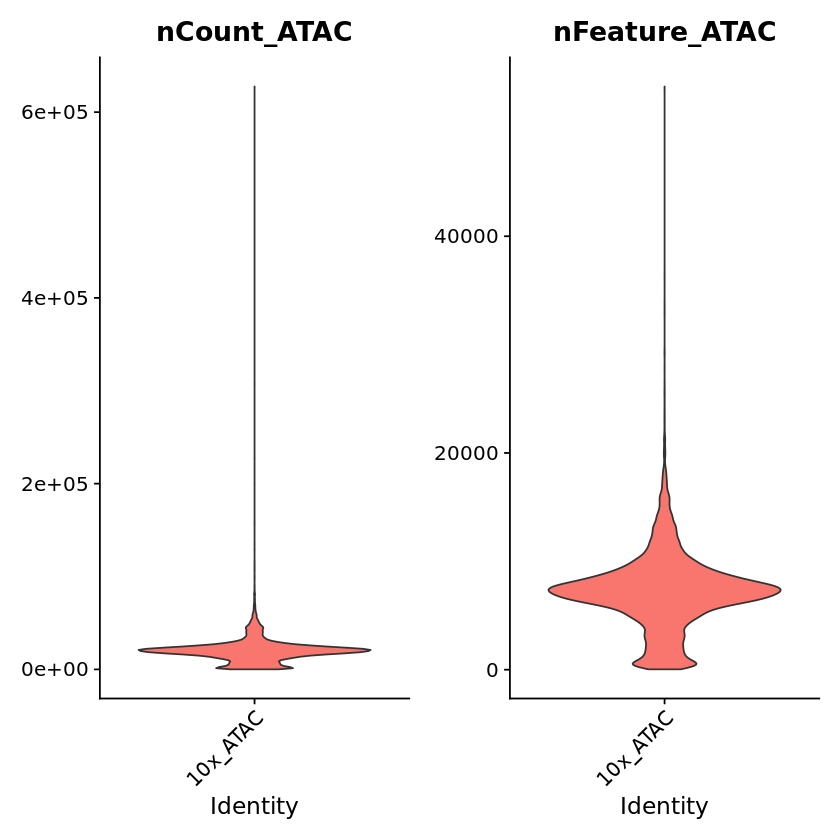

In [7]:
VlnPlot(
  object = atac,
  features = c("nCount_ATAC", "nFeature_ATAC"),
    ncol = 2,
  pt.size = 0, 
)

In [13]:
str(atac@meta.data)

'data.frame':	11909 obs. of  5 variables:
 $ orig.ident       : Factor w/ 1 level "10x_ATAC": 1 1 1 1 1 1 1 1 1 1 ...
 $ nCount_ATAC      : num  55582 20495 16674 2007 7658 ...
 $ nFeature_ATAC    : int  13878 7253 6528 906 3323 4267 11633 7245 8602 7719 ...
 $ nCount_ACTIVITY  : num  40977 15242 12044 1532 5652 ...
 $ nFeature_ACTIVITY: int  6223 3985 3553 643 2075 2520 5522 3958 4216 4088 ...


Warning message:
“Removed 5857 rows containing non-finite values (stat_ydensity).”


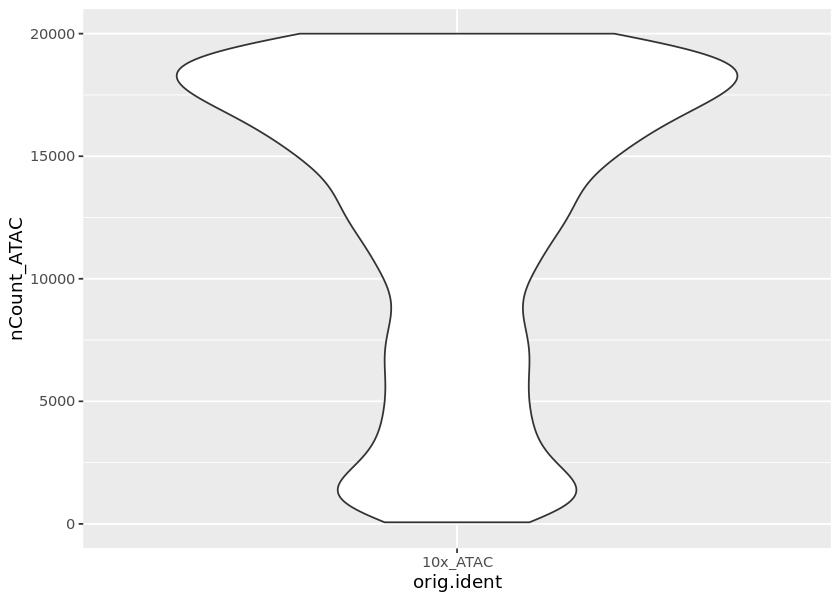

In [16]:
ggplot(atac@meta.data, aes(x = orig.ident, y = nCount_ATAC)) + geom_violin() + scale_y_continuous(limit = c(0, 2e4))

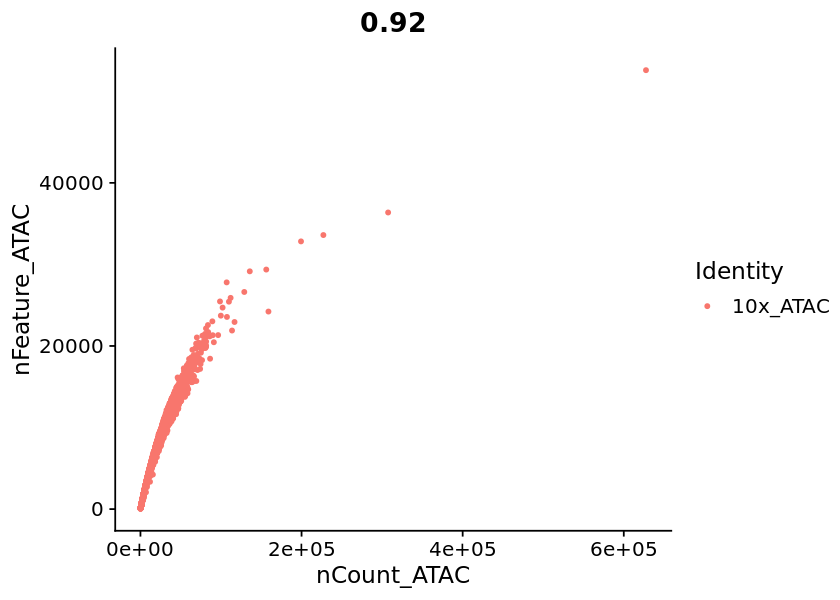

In [8]:
options(repr.plot.width = 7, repr.plot.height = 5)
FeatureScatter(atac, feature1 = "nCount_ATAC", feature2 = "nFeature_ATAC")

In [14]:
atac <- subset(atac, subset = nCount_ATAC > 5000)
atac$tech <- "atac"

In [15]:
DefaultAssay(atac) <- "ACTIVITY"
atac <- FindVariableFeatures(atac)
atac <- NormalizeData(atac)
atac <- ScaleData(atac)

Centering and scaling data matrix



In [16]:
DefaultAssay(atac) <- "ATAC"
VariableFeatures(atac) <- names(which(Matrix::rowSums(atac) > 100))
atac <- RunLSI(atac, n = 50, scale.max = NULL)
atac <- RunUMAP(atac, reduction = "lsi", dims = 1:50)

Warning message:
"RunLSI is being moved to Signac. Equivalent functionality can be achieved via the Signac::RunTFIDF and Signac::RunSVD functions; for more information on Signac, please see https://github.com/timoast/Signac"
Warning message:
"RunLSI is being moved to Signac. Equivalent functionality can be achieved via the Signac::RunTFIDF and Signac::RunSVD functions; for more information on Signac, please see https://github.com/timoast/Signac"
Warning message:
"RunLSI is being moved to Signac. Equivalent functionality can be achieved via the Signac::RunTFIDF and Signac::RunSVD functions; for more information on Signac, please see https://github.com/timoast/Signac"
Performing TF-IDF normalization

Running SVD on TF-IDF matrix

Scaling cell embeddings

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlati

In [17]:
saveRDS(atac, "atac.rds")

# Making RNA object

### QC & preprocessing

In [18]:
rna <- CreateSeuratObject(counts = genes, assay = "RNA", project = "10k_RNA", min.cells = 3, min.features = 200)
rna$tech <- "rna"

In [19]:
rna

An object of class Seurat 
26346 features across 11852 samples within 1 assay 
Active assay: RNA (26346 features, 0 variable features)

In [20]:
rna[["percent.mt"]] <- PercentageFeatureSet(rna, pattern = "^MT-")

In [21]:
head(rna@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,tech,percent.mt
,<fct>,<dbl>,<int>,<chr>,<dbl>
AAACAGCCAAGGAATC-1,10k_RNA,8379,3307,rna,7.471059
AAACAGCCAATCCCTT-1,10k_RNA,3770,1895,rna,10.530504
AAACAGCCAATGCGCT-1,10k_RNA,6875,2903,rna,6.458182
AAACAGCCACACTAAT-1,10k_RNA,1733,846,rna,18.003462
AAACAGCCACCAACCG-1,10k_RNA,5413,2281,rna,6.502863
AAACAGCCAGGATAAC-1,10k_RNA,2759,1353,rna,6.922798


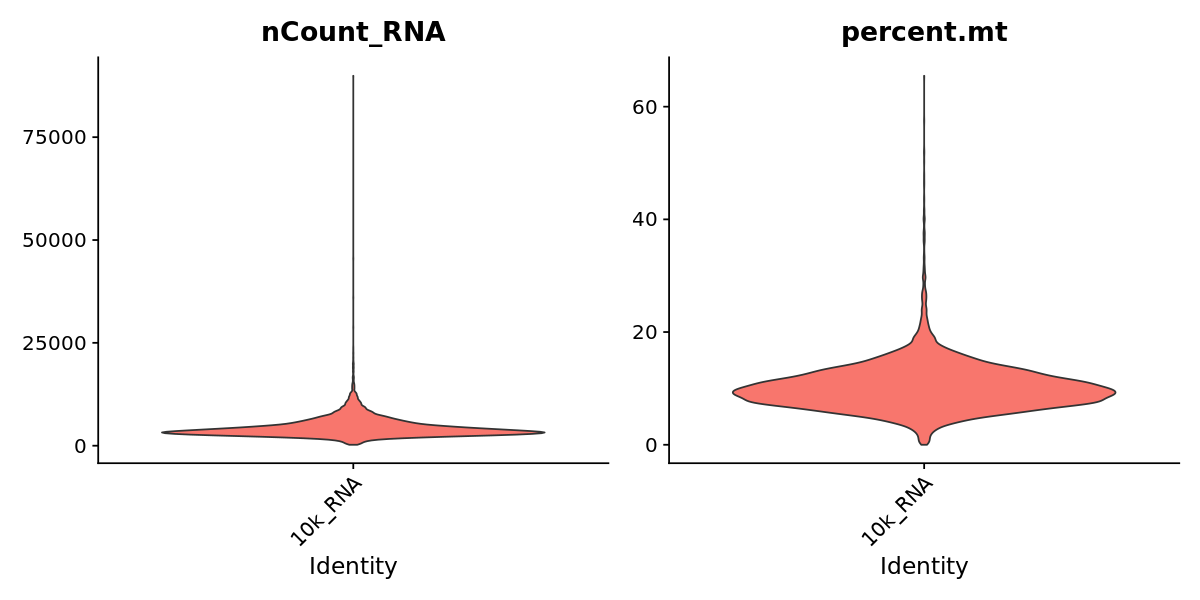

In [22]:
VlnPlot(
  object = rna,
  features = c("nCount_RNA", "percent.mt"),
    ncol = 2,
  pt.size = 0
)

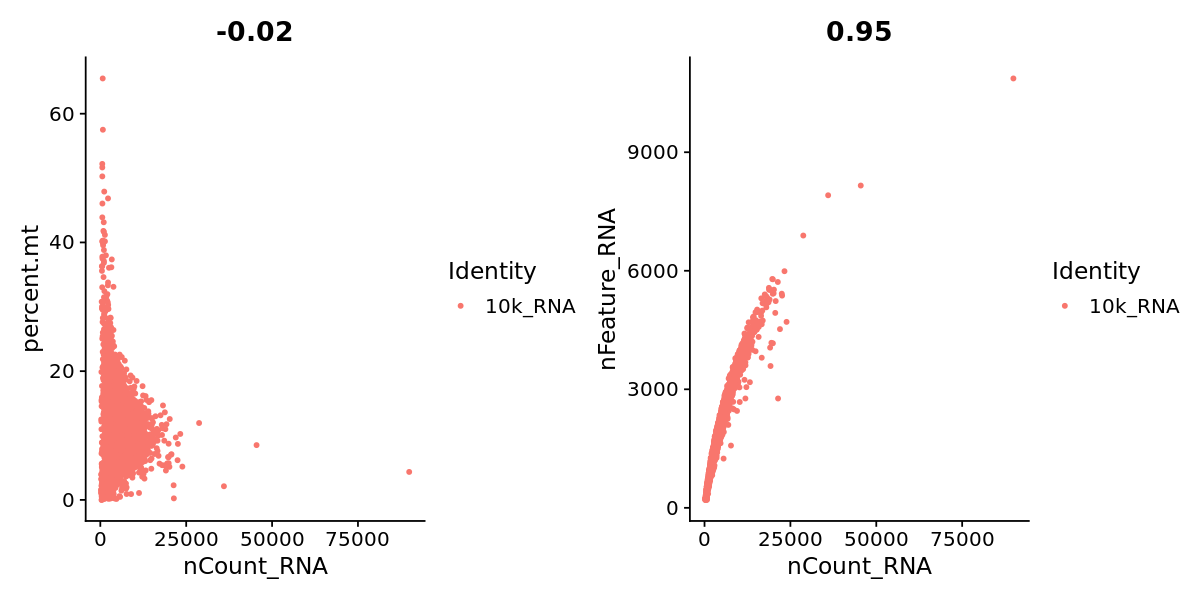

In [23]:
options(repr.plot.width = 10, repr.plot.height = 5)
plot1 <- FeatureScatter(rna, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(rna, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

In [25]:
rna <- subset(rna, subset = percent.mt < 20 & nCount_RNA < 25000 & nCount_RNA > 1000)
rna <- NormalizeData(rna, normalization.method = "LogNormalize", scale.factor = 10000)

In [26]:
rna <- FindVariableFeatures(rna, selection.method = "vst", nfeatures = 2000)

In [27]:
all.genes <- rownames(rna)
rna <- ScaleData(rna, features = all.genes)

Centering and scaling data matrix



In [19]:
# filter out low quality cells
rna <- subset(
  x = rna,
  subset = nCount_RNA < 25000 &
    nCount_RNA > 1000
)
rna

An object of class Seurat 
36601 features across 11725 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

In [33]:
rna <- RunPCA(rna, features = VariableFeatures(object = rna))

PC_ 1 
Positive:  RPS29, CD247, IL32, CAMK4, IL7R, LEF1, LTB, BACH2, INPP4B, BCL2 
	   SYNE2, THEMIS, TRBC2, RORA, TXK, ANK3, TPT1, CD69, TRBC1, NR3C2 
	   MLLT3, APBA2, RASGRF2, ACTG1, LINC01934, NELL2, TAFA1, SAMD3, PCAT1, PFN1 
Negative:  PLXDC2, SLC8A1, LRMDA, FCN1, TYMP, MCTP1, JAK2, RBM47, IRAK3, NAMPT 
	   DMXL2, ZEB2, TBXAS1, LYN, LRRK2, SAT1, GAB2, CYBB, TNFAIP2, TLR2 
	   CSF3R, CLEC7A, HCK, LYST, VCAN, DENND1A, FGD4, CD36, FAM49A, GRK3 
PC_ 2 
Positive:  CD247, IL32, DPYD, IL7R, AOAH, INPP4B, CAMK4, PDE3B, THEMIS, RORA 
	   TXK, LEF1, NEAT1, ARHGAP26, ANXA1, FNDC3B, SRGN, ADGRE5, SAMD3, NCALD 
	   TRBC1, CTSW, SYNE2, PLCB1, APBA2, CCL5, PRF1, S100A4, ID2, TGFBR3 
Negative:  BANK1, MS4A1, PAX5, FCRL1, NIBAN3, IGHM, AFF3, EBF1, LINC00926, OSBPL10 
	   CD79A, RALGPS2, CD22, COBLL1, BLK, BLNK, AP002075.1, IGHD, ADAM28, COL19A1 
	   BCL11A, CD79B, PLEKHG1, GNG7, DENND5B, WDFY4, AC120193.1, TCF4, SPIB, RUBCNL 
PC_ 3 
Positive:  GZMB, NKG7, GNLY, PRF1, KLRD1, GZMA, CST7, CCL5, FGFB

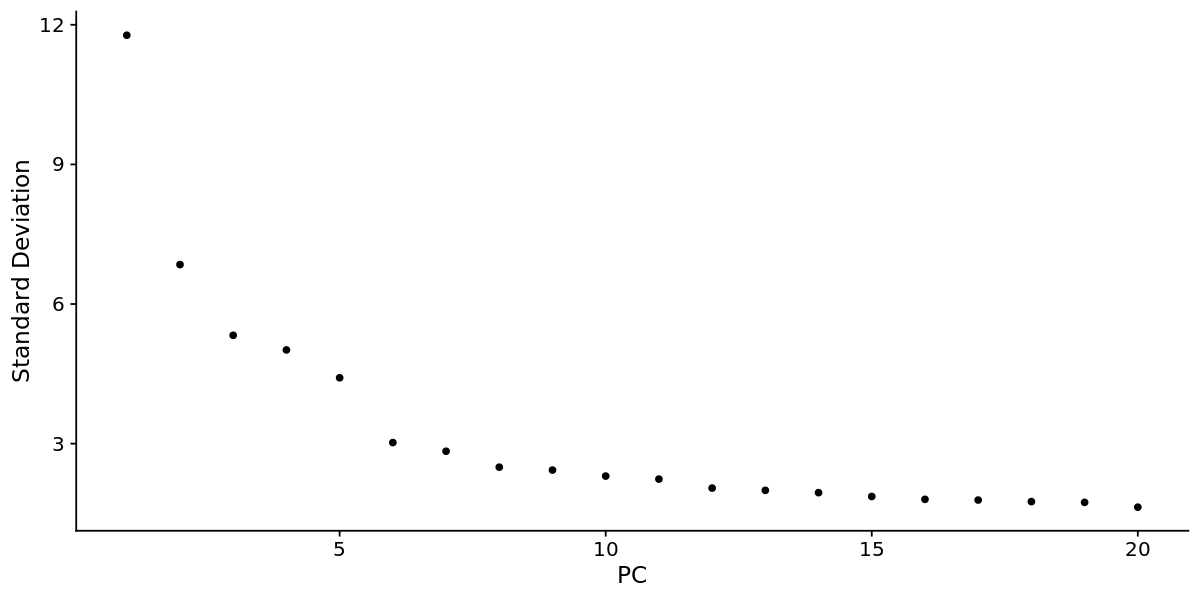

In [34]:
ElbowPlot(rna)

In [35]:
rna <- FindNeighbors(rna, dims = 1:20)
rna <- FindClusters(rna, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 11616
Number of edges: 427688

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9134
Number of communities: 17
Elapsed time: 1 seconds


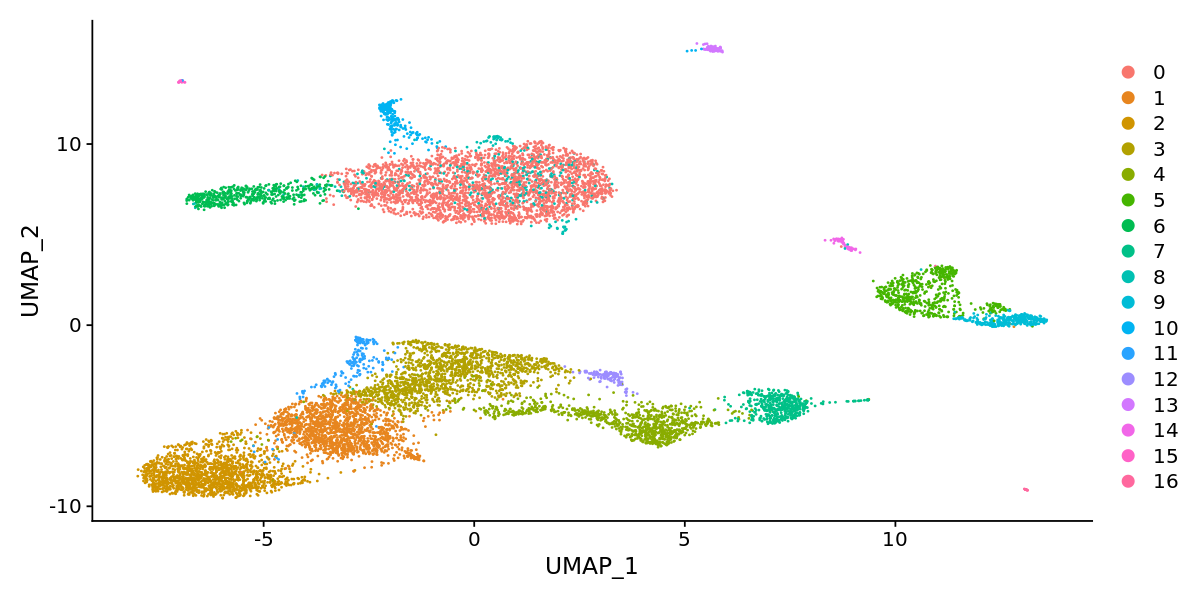

In [37]:
#rna <- RunUMAP(rna, dims = 1:20)
DimPlot(rna, reduction = "umap")

In [40]:
saveRDS(rna, "rna.rds")

In [77]:
rna <- readRDS("rna.rds")

Warning message:
“CombinePlots is being deprecated. Plots should now be combined using the patchwork system.”


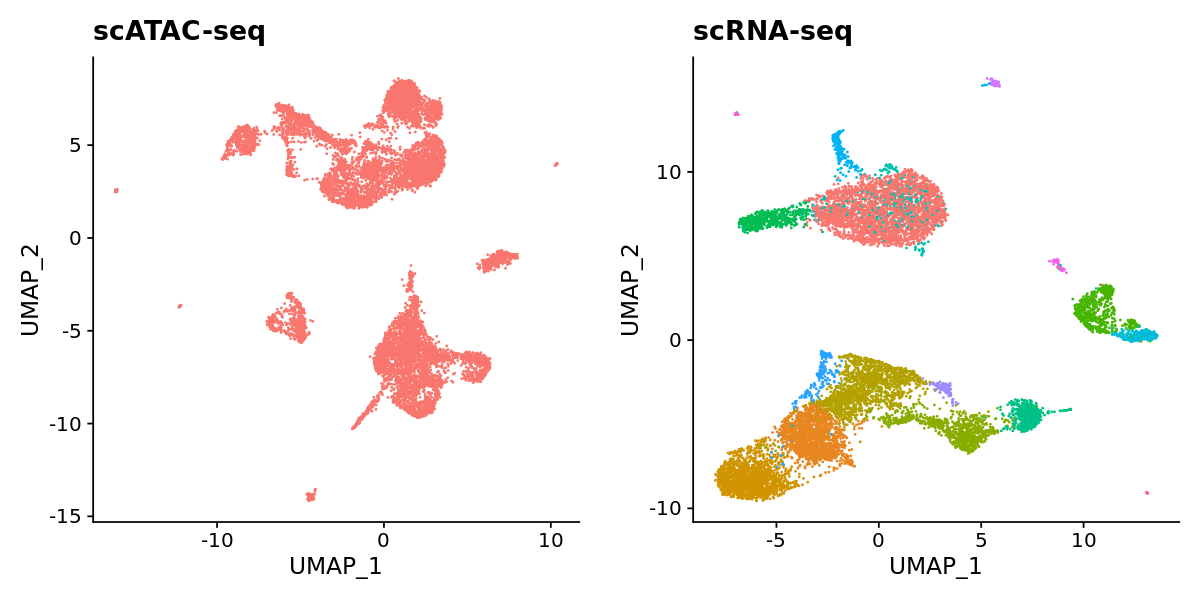

In [38]:
p1 <- DimPlot(atac, reduction = "umap") + NoLegend() + ggtitle("scATAC-seq")
p2 <- DimPlot(rna, reduction = "umap") + NoLegend() + ggtitle("scRNA-seq")
CombinePlots(plots = list(p1, p2))

# Co-embedding

In [23]:
shared_cells = intersect(colnames(x = rna[["RNA"]]), colnames(x = atac[["ATAC"]]))

In [24]:
length(shared_cells)

[1] 10526

In [25]:
rna = subset(rna, cells = shared_cells)
atac = subset(atac, cells = shared_cells)

In [9]:
revert_cid <- function(str_v){
    sapply(strsplit(str_v, split = ".", fixed = TRUE), function(l) l[2])
}

In [12]:
rna <- RenameCells(rna, new.names =  paste0("rna.", colnames(x = rna[["RNA"]])))
atac <- RenameCells(atac, new.names = paste0("atac.", colnames(x = atac[["ATAC"]])))

In [13]:
transfer.anchors <- FindTransferAnchors(reference = rna, query = atac, features = VariableFeatures(object = rna), 
    reference.assay = "RNA", query.assay = "ACTIVITY", reduction = "cca")

Warning message in RunCCA.Seurat(object1 = reference, object2 = query, features = features, :
“Running CCA on different assays”
Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 26083 anchors

Filtering anchors

	Retained 3500 anchors



In [14]:
# note that we restrict the imputation to variable genes from scRNA-seq, but could impute the
# full transcriptome if we wanted to
genes.use <- VariableFeatures(rna)
refdata <- GetAssayData(rna, assay = "RNA", slot = "data")[genes.use, ]

# refdata (input) contains a scRNA-seq expression matrix for the scRNA-seq cells.  imputation
# (output) will contain an imputed scRNA-seq matrix for each of the ATAC cells
imputation <- TransferData(anchorset = transfer.anchors, refdata = refdata, weight.reduction = atac[["lsi"]])

# this line adds the imputed data matrix to the atac object
atac[["RNA"]] <- imputation
coembed <- merge(x = rna, y = atac)

# Finally, we run PCA and UMAP on this combined object, to visualize the co-embedding of both
# datasets
coembed <- ScaleData(coembed, features = genes.use, do.scale = FALSE)
coembed <- RunPCA(coembed, features = genes.use, verbose = FALSE)
coembed <- RunUMAP(coembed, dims = 1:30)
#coembed$celltype <- ifelse(!is.na(coembed$celltype), coembed$celltype, coembed$predicted.id)

Finding integration vectors

Finding integration vector weights

Transfering 2000 features onto reference data

Centering data matrix

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
10:25:45 UMAP embedding parameters a = 0.9922 b = 1.112

10:25:45 Read 21052 rows and found 30 numeric columns

10:25:45 Using Annoy for neighbor search, n_neighbors = 30

10:25:45 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:25:52 Writing NN index file to temp file /tmp/RtmpXYSwgD/file3efbf796196d4

10:25:52 Searching Annoy index using 1 thread, sea

In [1]:
coembed <- readRDS("coembed-matched.rds")

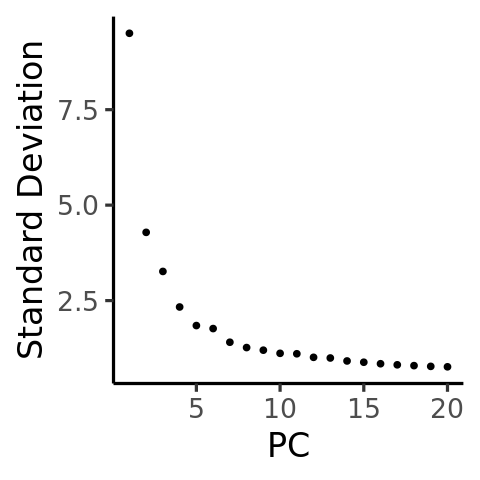

In [5]:
options(repr.plot.width = 4, repr.plot.height = 4)
library(ggplot2)
ElbowPlot(coembed) + theme_classic(base_size = 20)

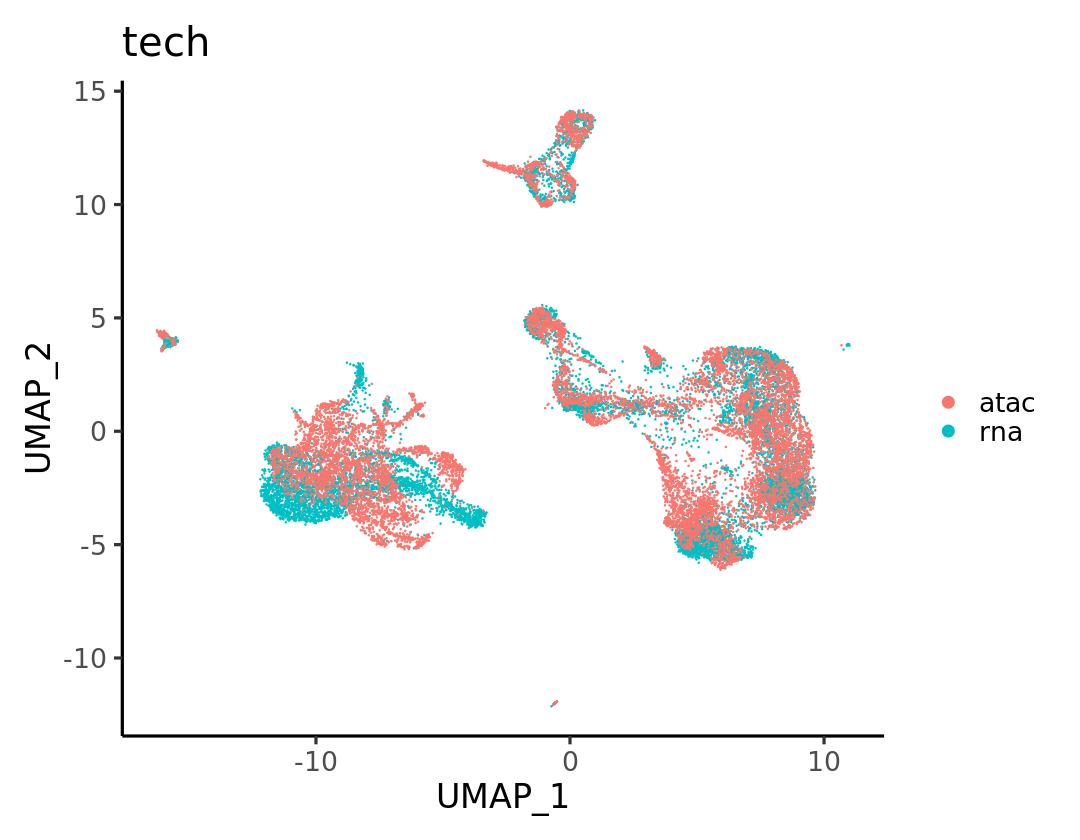

In [15]:
options(repr.plot.width = 9, repr.plot.height = 7)
DimPlot(coembed, group.by = "tech") + theme_classic(base_size = 20)

In [16]:
rna_cells = colnames(rna[['RNA']])
atac_cells = colnames(atac[["ATAC"]])

In [18]:
imputed_gexp = coembed[['RNA']][genes.use,]
str(imputed_gexp)

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:12911050] 24 34 39 42 45 55 63 73 85 95 ...
  ..@ p       : int [1:21053] 0 215 360 540 689 775 953 1057 1359 1474 ...
  ..@ Dim     : int [1:2] 2000 21052
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:2000] "JCHAIN" "PTGDS" "IGKC" "IGHA1" ...
  .. ..$ : chr [1:21052] "rna.AAACAGCCAAGGAATC-1" "rna.AAACAGCCAATCCCTT-1" "rna.AAACAGCCAATGCGCT-1" "rna.AAACAGCCACCAACCG-1" ...
  ..@ x       : num [1:12911050] 0.785 1.22 0.785 0.785 0.785 ...
  ..@ factors : list()


In [19]:
saveRDS(coembed, "coembed-matched.rd")

In [1]:
coembed <- readRDS("coembed-matched.rds")

In [17]:
# This 'coembed' object only has integrated features for its RNA slot for genes.use
all(coembed[["ATAC"]][,rna_cells] == 0)
all_genes = rownames(coembed[['RNA']])
unused_genes = all_genes[! all_genes %in% genes.use]
all(coembed[["RNA"]][unused_genes,atac_cells] == 0)

[1] TRUE

[1] TRUE

## Incorporate cell type

In [6]:
meta <- read.table("../../data/pbmc/cell_type.txt", stringsAsFactors = F, head = T)

In [26]:
str(meta)

'data.frame':	11536 obs. of  2 variables:
 $ cluster: int  3 1 2 3 3 2 3 1 6 3 ...
 $ bc     : chr  "AAACAGCCAAGGAATC-1" "AAACAGCCAATCCCTT-1" "AAACAGCCAATGCGCT-1" "AAACAGCCACACTAAT-1" ...


In [22]:
meta.ft = c(meta$cluster, meta$cluster)
names(meta.ft) = c(paste0("rna.", meta$bc), paste0("atac.", meta$bc))

In [27]:
all(coembed[["RNA"]]@data[, rna_cells] == rna[["RNA"]]@data)

[1] TRUE

In [31]:
embedding = as.data.frame(coembed@reductions$pca@cell.embeddings)
embedding$cell_type = factor(meta.ft[rownames(embedding)])

In [28]:
str(embedding$cell_type)

 int [1:21052] 3 1 2 3 2 3 1 6 3 7 ...


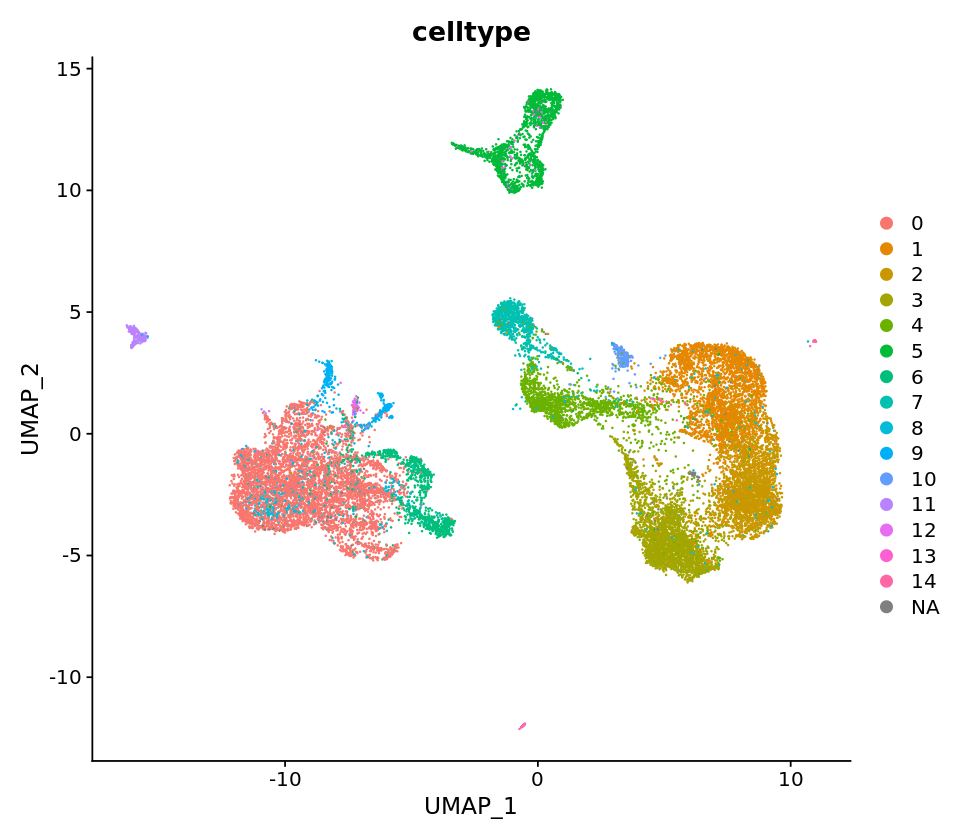

In [24]:
options(repr.plot.width = 8, repr.plot.height = 7)
coembed$celltype = meta.ft
DimPlot(coembed, group.by = "celltype")

In [1]:
embedding <- read.table("integrated_embedding.txt")

In [2]:
embedding$batch = as.numeric(factor(sapply(strsplit(rownames(embedding), split = ".", fixed = T), function(s) paste0(s[2:length(s)], collapse = "."))))

In [3]:
write.table(embedding, "integrated_embedding.txt", quote = F, sep = "\t", row.names = T, col.names = T)